In [1]:
pip install tinkoff-investments

Note: you may need to restart the kernel to use updated packages.


In [132]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
import csv
from statsmodels.tsa.arima.model import ARIMA

from datetime import date
from tinkoff.invest import CandleInterval, Client, InstrumentStatus
from tinkoff.invest.services import InstrumentsService, MarketDataService
from tinkoff.invest.schemas import CandleSource
from tinkoff.invest.utils import now
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf




In [5]:
TOKEN = "t.h4d5TSQa5bCYYIuLngkOL_exhWhUMxxH8WriKm3YKFdE5_U70d5LnRRG04shjnijR5gczdmb6Yq2SSCkgzutFQ"

In [133]:
with Client(TOKEN) as client:
    with open('data.csv', mode='w', newline='') as file:
        fieldnames = ['Close']  # Заголовки столбцов
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        
        for candle in client.get_all_candles(
            instrument_id="BBG004RVFFC0",
            from_=now() - timedelta(days=2000),
            interval=CandleInterval.CANDLE_INTERVAL_DAY,
            candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
        ):
            cand = candle.close.units
            writer.writerow({'Close': cand})

In [162]:
data_closed = pd.read_csv('data.csv')
print(data_closed)

      Close
0       705
1       705
2       725
3       714
4       712
...     ...
1359    721
1360    728
1361    729
1362    731
1363    739

[1364 rows x 1 columns]


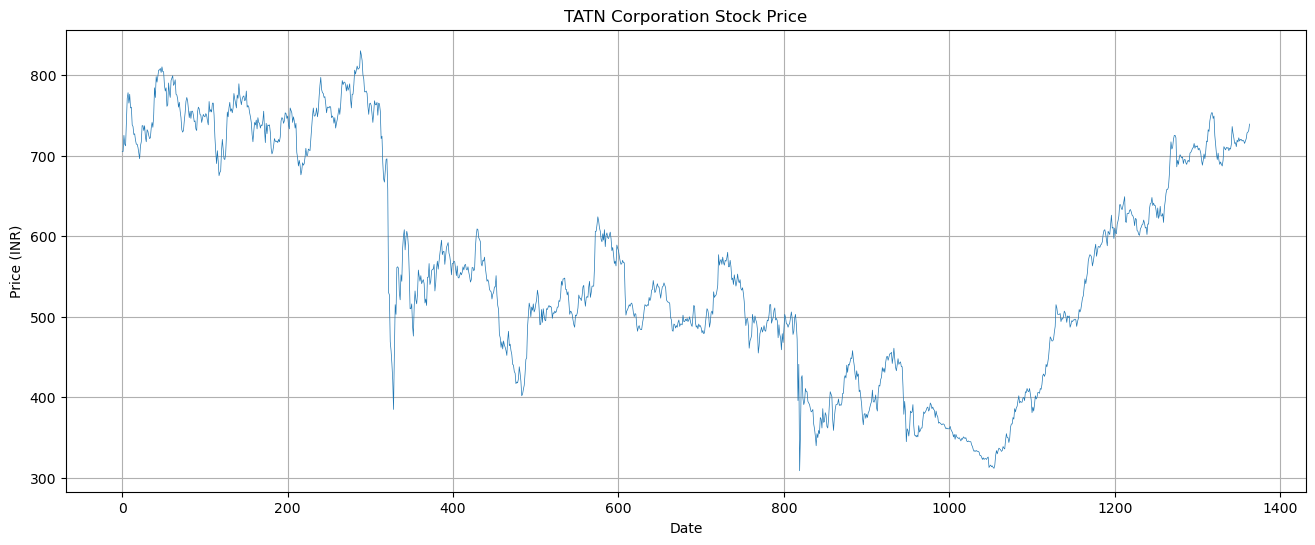

In [254]:
plt.figure(figsize=(16, 6))
plt.plot(data_closed['Close'], linewidth=0.5)
plt.title("TATN Corporation Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

In [164]:
train = pd.DataFrame(data_closed[0:int(len(data_closed))])
# test = pd.DataFrame(data_closed[int(len(data_closed)*0.70): int(len(data_closed))])

print(train)
# print(test.shape)

      Close
0       705
1       705
2       725
3       714
4       712
...     ...
1359    721
1360    728
1361    729
1362    731
1363    739

[1364 rows x 1 columns]


In [166]:
# Делаем нормализацию данных
scaler = MinMaxScaler()
data_closed_scaled = pd.DataFrame(scaler.fit_transform(data_closed), columns=data_closed.columns) # применяем скалирование

In [167]:
data_closed_scaled

,Close
0,0.760077
1,0.760077
2,0.798464
3,0.777351
4,0.773512
...,...
1359,0.790787
1360,0.804223
1361,0.806142
1362,0.809981


In [168]:
# Выделяем сегмент для тренировки сети и сегмент для тестирования натренированной сети в отношении 1/4
train, test = train_test_split(data_closed_scaled, test_size=0.2, shuffle=False)

In [169]:
print(train.head())
print(test.head())

      Close
0  0.760077
1  0.760077
2  0.798464
3  0.777351
4  0.773512
         Close
1091  0.166987
1092  0.188100
1093  0.186180
1094  0.195777
1095  0.190019


In [170]:
# Определяем структуру нашей модели
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, 1))) # Первый слой - это LSTM сеть
model.add(Dense(1)) # второй слой - обычная линейная регрессия
model.compile(optimizer='adam', loss='mean_squared_error') # в качестве метода оптимизации используем стохастический градиентный метод, в качестве целевой функции среднюю квадратичную ошибку

D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [171]:
# Готовим данные для обучения сети
window_size = 10  # Выбираем размер окна для формирования предсказания
# Готовим тренировочные данные - выбираем окна размером 10 и для каждого окна ожидаемый результат 11-ое значение
X_train = np.array([train.iloc[i-window_size:i].values for i in range(window_size, len(train))])
y_train = train.iloc[window_size:, 0].values
# Аналогично готовим данные для проверки качества обучения сети
X_test = np.array([test.iloc[i-window_size:i].values for i in range(window_size, len(test))])
y_test = test.iloc[window_size:, 0].values
# Преобразовываем данные в формат входа LSTM модели
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

In [172]:
print(train[:31])
print(X_train[0])
print(X_train[1])
print(y_train)

       Close
0   0.760077
1   0.760077
2   0.798464
3   0.777351
4   0.773512
5   0.833013
6   0.886756
7   0.900192
8   0.875240
9   0.896353
10  0.863724
11  0.865643
12  0.823417
13  0.819578
14  0.800384
15  0.802303
16  0.786948
17  0.777351
18  0.777351
19  0.769674
20  0.756238
21  0.742802
22  0.773512
23  0.783109
24  0.821497
25  0.821497
26  0.809981
27  0.821497
28  0.794626
29  0.783109
30  0.811900
[[0.76007678]
 [0.76007678]
 [0.79846449]
 [0.77735125]
 [0.77351248]
 [0.83301344]
 [0.88675624]
 [0.90019194]
 [0.87523992]
 [0.89635317]]
[[0.76007678]
 [0.79846449]
 [0.77735125]
 [0.77351248]
 [0.83301344]
 [0.88675624]
 [0.90019194]
 [0.87523992]
 [0.89635317]
 [0.86372361]]
[0.86372361 0.86564299 0.82341651 ... 0.16314779 0.17274472 0.17466411]


In [283]:
# Обучаем модель
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6469e-04 - val_loss: 2.7822e-04
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4877e-04 - val_loss: 2.3120e-04
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2083e-04 - val_loss: 2.3892e-04
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4069e-04 - val_loss: 2.2888e-04
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2456e-04 - val_loss: 2.5436e-04
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1557e-04 - val_loss: 2.8170e-04
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7703e-04 - val_loss: 2.5490e-04
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8253e-04 - val_loss: 2.4613e-04
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2608e-04 - val_loss: 2.6099e-04
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6258e-04 - val_loss: 2.3379e-04


In [284]:
# Вычисляем отклонение по целевой функции
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6595e-04 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2643e-04 
Train Loss: 0.0006441760924644768
Test Loss: 0.00023378717014566064


Getting recent data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted price is:  [[778.2773]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted price is:  [[761.4299]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted price is:  [[762.3812]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted price is:  [[739.1218]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted price is:  [[737.02496]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted price is:  [[727.91187]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted price is:  [[728.99445]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted price is:  [[721.2796]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted price is:  [[715.72076]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted price is:  [[716.1419]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted price is:  [[712.1412]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted price is:  [[704.7423]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted price is:  [[697.51074]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

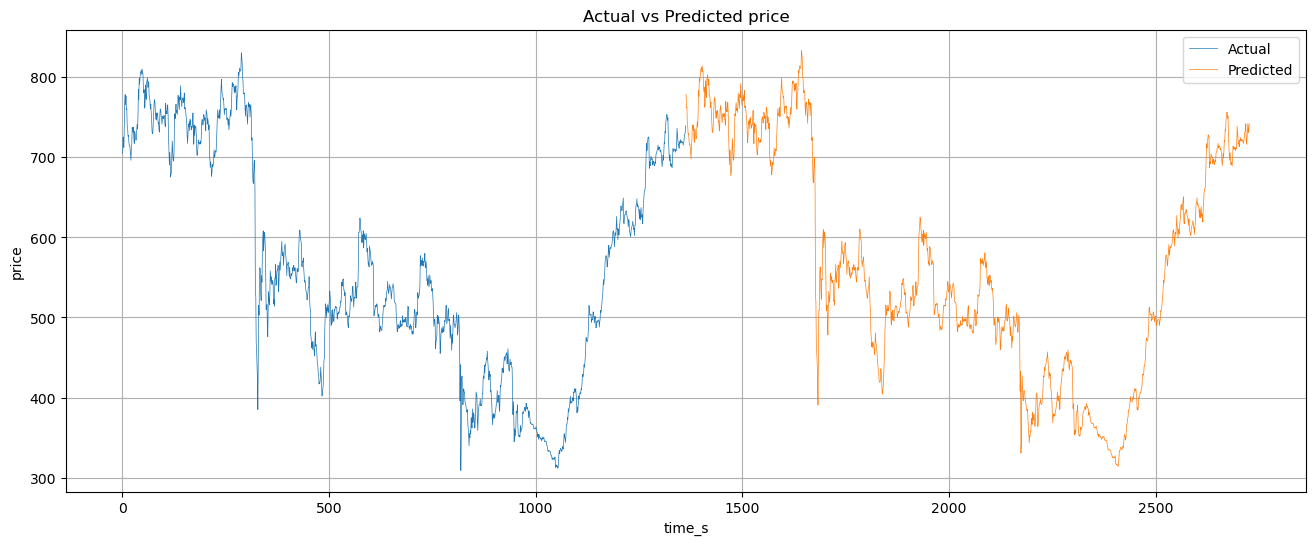

In [285]:
# Делаем прогноз
print("Getting recent data...")
window_size = 10 

# Создаем список для хранения прогнозов
forecasts = []

# Текущий индекс в массиве данных
current_index = 0

# Индекс последнего элемента в выборке
last_element_index = len(data_closed_scaled)-1

# Проходим по всем данным, используя сдвигающиеся окна
while current_index < len(data_closed_scaled):
    # Выбираем данные для прогнозирования
    recent_data = data_closed_scaled['Close'][current_index:last_element_index]

    # Преобразуем данные в нужный формат для модели
    recent_data = np.resize([(recent_data)], window_size).reshape(1, window_size, 1)
    
    # Делаем прогноз
    predicted_value_scaled = model.predict(recent_data)
    
    # Преобразуем обратно в исходное значение
    predicted_value = scaler.inverse_transform(predicted_value_scaled)
    print("predicted price is: ", predicted_value)
    
    # Добавляем прогноз в список результатов
    forecasts.append(predicted_value)
    
    # Увеличиваем текущий индекс и обновляем индекс последнего элемента
    current_index += 1
    last_element_index = current_index + window_size

# Проверяем, что мы обработали все данные
assert current_index == len(data_closed_scaled), "Не все данные были обработаны"

forecasts
real_data = data_closed['Close']
forecasts = np.squeeze(forecasts)
predicted_df = pd.DataFrame(forecasts, columns=['Predicted'], index=range(len(data_closed), len(data_closed) + len(forecasts)))

# Объединяем реальные данные и прогнозы в один DataFrame
combined_data = pd.concat([real_data, predicted_df], axis=1)

# Устанавливаем заголовки для столбцов
combined_data.columns = ['Actual', 'Predicted']

# Создаем график
plt.figure(figsize=(16, 6))
plt.plot(combined_data, linewidth=0.5)
plt.title('Actual vs Predicted price')
plt.xlabel('time_s')
plt.ylabel('price')
plt.legend(['Actual', 'Predicted'])
plt.grid()
plt.show()
